In [1]:
using IL4model
using Plots

┌ Info: Precompiling IL4model [340beedc-db60-444a-b2c9-cf3fe37ee138]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1317


13764.526561651823

In [2]:
results = optimizeParam()

 * Status: success

 * Candidate solution
    Final objective value:     1.242412e+02

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 2.53e-24 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.53e-30 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.84e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-16 ≤ 1.0e-11
    |g(x)|                 = 2.16e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    411
    f(x) calls:    315
    ∇f(x) calls:   315
    ∇²f(x) calls:  259


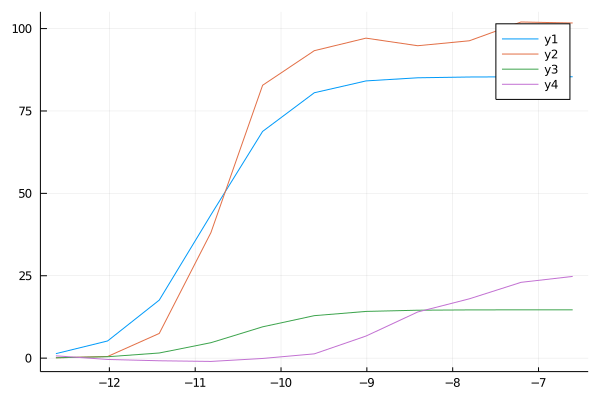

In [3]:
fitOut = abs.(Optim.minimizer(results))
plot(concs, ligOutLs(concs, fitOut[1:7])[:, 3])
plot!(concs, IL4sig)
plot!(concs, ligOutLs(concs, fitOut[[1, 8, 9, 10, 5, 6, 7]])[:, 3])
plot!(concs, neo4sig)

In [21]:
fitOut

10-element Vector{Float64}:
     1.0000000000018305e6
     2.037945768058388e-11
     0.04596714547983887
     0.06744345914038435
  1000.0075442025119
 12000.000008317085
  8000.000956567346
     2.526545213328506e-10
     0.0016353086701638292
     0.06867295232973315